# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [2]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

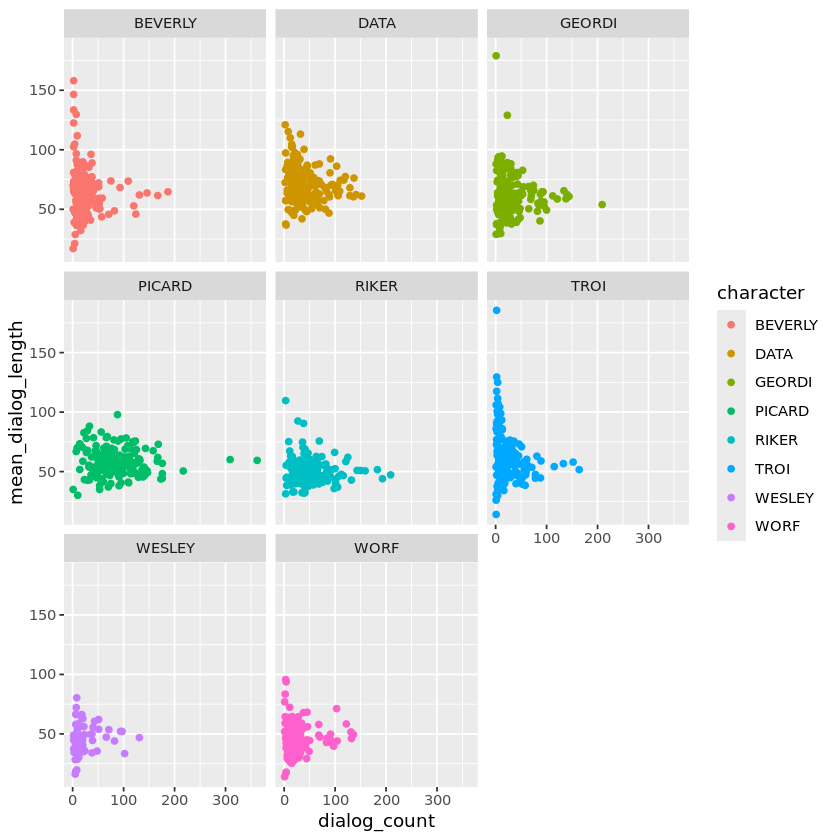

In [3]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

There are two criteria we can look at to determine the role of a character in the plot. First, the mean of the distribution can tell us how long on average a character is speaking for, which in turn can tell us their significance to the plot. The second criteria is the variance of the distribution itself, which tells us how much their significance to the plot tends to vary. The higher the variance, the higher chance that the character tends to fluctuate in importance from a main character in an episode to side or  trivial character in another. For example, looking at the show's main character Picard, we see that his distribution is quite compact with little variance with an average dialog length of about 50-60 with some outlier episodes where his dialog count is is very high even with that average length. We can disregard the height of the distribution for a majority of the characters since they tend to come out the same, telling us that the majority of them have similar dialog counts. However, for Wesley and Worf, we have compact distributions with an average dialog length of 50 or less with smaller dialog counts, telling us that these characters are more side characters than main characters when compared to the others.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`. 
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season. 

In [48]:
beverly <- dialogs %>% 
filter(character == "BEVERLY" & (episode_number %in% 102:126 | episode_number %in% 149:174)) 
beverly <- beverly %>% mutate(season = case_when(episode_number < 127 ~ 1, episode_number > 126 ~ 3)) %>% 
group_by(season, episode_number) %>% summarize(mean_per_episode = mean(str_length(dialog)), .groups = "drop")
beverly %>% group_by(season) %>% summarize(mean_of_means = mean(mean_per_episode), .groups = "drop")

beverly_count <- dialogs %>% filter(character == "BEVERLY" & (episode_number %in% 102:126 | episode_number %in% 149:174))
beverly_count <- beverly_count %>% mutate(season = case_when(episode_number < 127 ~ 1, episode_number > 126 ~ 3)) %>% 
group_by(season, episode_number) %>% summarize(mean_dialog_count = n(), .groups = "drop")
beverly_count %>% group_by(season) %>% summarize(mean_of_count_means = mean(mean_dialog_count), .groups = "drop")

season,mean_of_means
<dbl>,<dbl>
1,56.48460
3,67.04817


season,mean_of_count_means
<dbl>,<dbl>
1,25.40
3,19.64


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

We can see that in the first table that her average dialog length increased per episode after her switch in season 3 and in our second table we can see that her average dialog count per episode actually decreased. Looking at these results, we could extrapolate a possibility that the actress's character did become more male-like since her overall importance in the plot did increase (with the increased average length) but at the cost of the number of times they spoke (so they possibly got more possible action scenes but that meant less amount of dialog).

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character. 
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [54]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)
tokens <- dialogs %>%
  # Split each dialog into words
  mutate(word_list = str_split(dialog, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% stop_words)

#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [62]:
tokens <- tokens %>% group_by(character) %>% summarize(unique_words = n_distinct(word), total_words = n(), vocab_richness = unique_words/total_words) %>%
arrange(desc(vocab_richness))
tokens

character,unique_words,total_words,vocab_richness
<chr>,<int>,<int>,<dbl>
AD LIBBED VOICES,7,7,1
ADMIRAL SIMONS,4,4,1
ALANS,14,14,1
ALEXANDRA,3,3,1
ALIEN,17,17,1
ALIEN NURSE,14,14,1
ALL IN GROUP,3,3,1
AMERICAN INDIAN,2,2,1
ANNA'S VOICE,2,2,1


#### c) Plot total words versus vocab richness. 
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

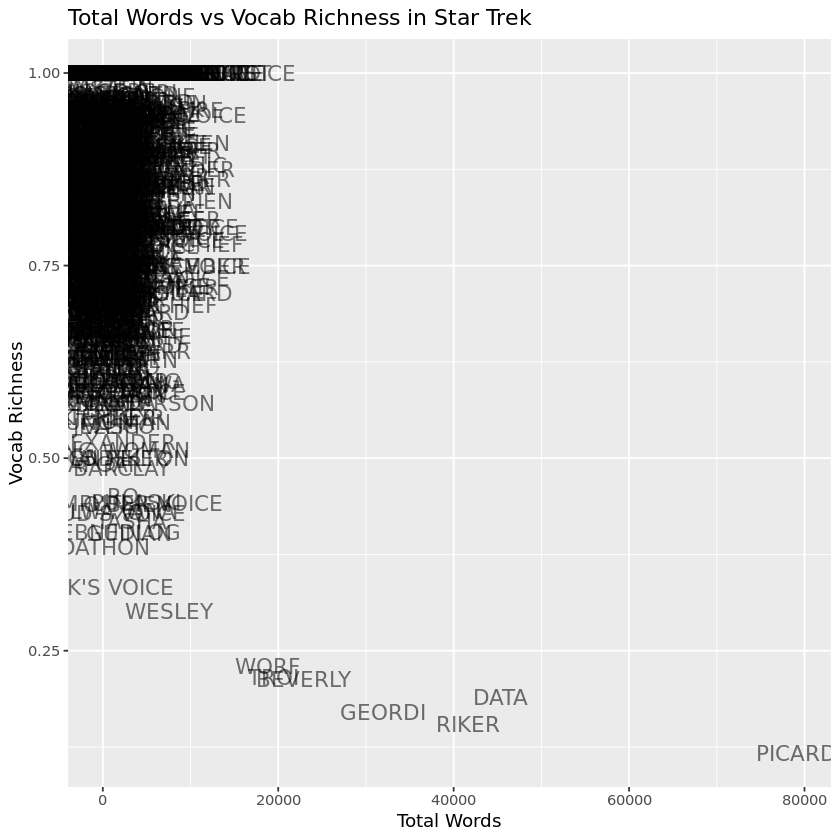

In [72]:
ggplot(tokens, aes(x = total_words, y = vocab_richness)) + geom_text(aes(label = character, size = .1, alpha = 0.5)) + theme(legend.position = "none") + 
labs(title = "Total Words vs Vocab Richness in Star Trek", x = "Total Words", y = "Vocab Richness")

#### d) Interpret these results. 

The majority of characters in Star Trek have a very high vocabulary richness due to the fact they have a very small amount of total words and they all tend to be very unique, meanwhile we can pick out the main cast of the show just by looking at the outliers with low vocabulary richness because those are the characters that will be repeating a lot of what they say (maybe as part of an introduction or something) due to the sheer amount of total words spoken.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row. 
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap. 

In [75]:
wesley <- dialogs %>% filter(character == "WESLEY" & episode_number > 174)
wesley %>% group_by(episode_number) %>% summarise(dialog_count = n())

episode_number,dialog_count
<dbl>,<int>
175,18
176,6
177,9
178,6
179,38
181,2
183,94
206,131
219,71


The first major gap occurs from episode 183 to 206. So, Wesley leaves the show as a main character after episode 183.

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

He makes cameo appearances in episodes 206, 219, 263, and 272.

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [91]:
main_last_line <- dialogs_fixed %>% filter(character == "WESLEY" & episode_number == 183) %>% slice_tail(n=1)
print(main_last_line$dialog)

last_line <- dialogs_fixed %>% filter(character == "WESLEY" & episode_number == 272) %>% slice_tail(n=1)
print(last_line$dialog)

[1] "I can walk."
[1] "Good-bye, Mom."


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title. 
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

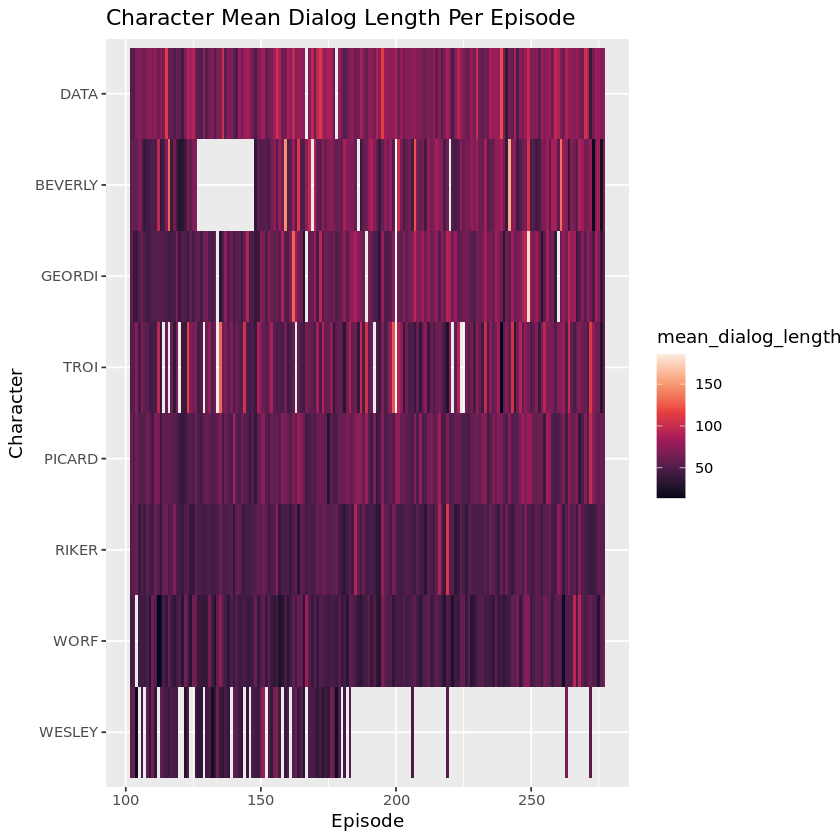

In [112]:
character_order <- dialog_len_per_ep %>% group_by(character) %>% summarize(overall_mean = mean(mean_dialog_length)) %>%
arrange(overall_mean) %>% pull(character)
dialog_len_per_ep <- dialog_len_per_ep %>% mutate(character = factor(character, levels = character_order))
ggplot(dialog_len_per_ep, aes(x = episode_number, y = character)) + geom_tile(aes(fill = mean_dialog_length)) + 
scale_fill_viridis_c(option = "rocket") + labs(title = "Character Mean Dialog Length Per Episode", x = "Episode", y = "Character")